#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [155]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, concatenate
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
from keras.optimizers import Adam

In [157]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [158]:
data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

data01_train.drop('subject', axis = 1, inplace = True)
data01_test.drop('subject', axis = 1, inplace = True)

#### 2) 기본 정보 조회

In [159]:
data01_train.shape

(5881, 562)

In [160]:
data01_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [161]:
data01_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [162]:
data01_train['is_dynamic'] = data01_train['Activity'].apply(lambda x : 0 if x in ['STANDING', 'SITTING', 'LAYING'] else 1)

### (2) x, y 분리

In [163]:
target = 'is_dynamic'
x = data01_train.drop(['Activity',target], axis = 1)
y = data01_train.loc[:, target]
activity_name = data01_train['Activity']

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [164]:
x_col_name = x.columns

scaler = StandardScaler()
x = scaler.fit_transform(x)

### (4) 데이터 분할
* train, val 분할

In [165]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

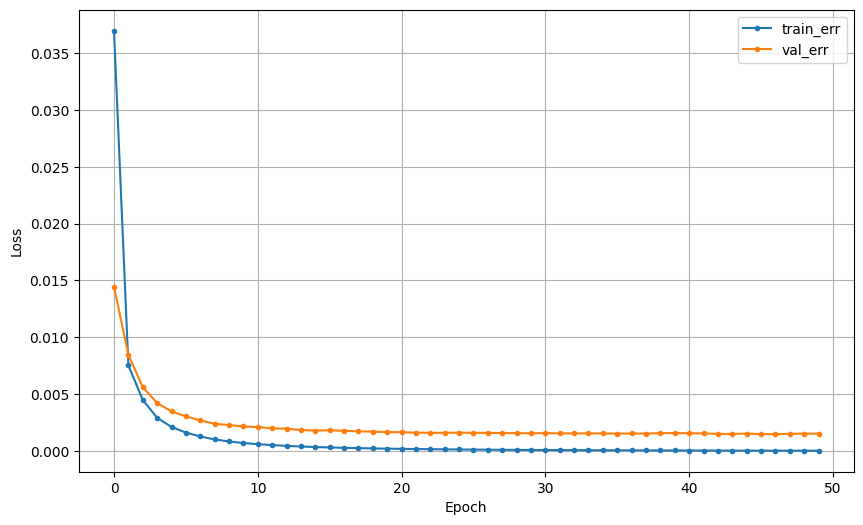

None
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[657   0]
 [  0 520]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       657
           1       1.00      1.00      1.00       520

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [166]:
nfeatures = x_train.shape[1]
#clear_session()

model_1 = Sequential([Input(shape=(nfeatures,)),
                    Dense(1, activation='sigmoid')])
model_1.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model_1.fit(x_train, y_train, epochs = 50, validation_split = 0.2, verbose = 0).history
print(dl_history_plot(hist))

pred_1 = model_1.predict(x_val)
pred_1 = np.where(pred_1 > 0.5, 1, 0)

print(confusion_matrix(y_val, pred_1))
print(classification_report(y_val, pred_1))

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [174]:
# 정적 데이터 분리 i = 0 -> data_0
i = 0
data = data01_train
globals()[f'data_{i}'] = data[data['is_dynamic'] == i]

target = 'Activity'
x = globals()[f'data_{i}'].drop(['is_dynamic', target], axis = 1)
y = globals()[f'data_{i}'].loc[:, target]

# 전처리
scaler = StandardScaler()
x = scaler.fit_transform(x)

encoder_0 = LabelEncoder()
y = encoder_0.fit_transform(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

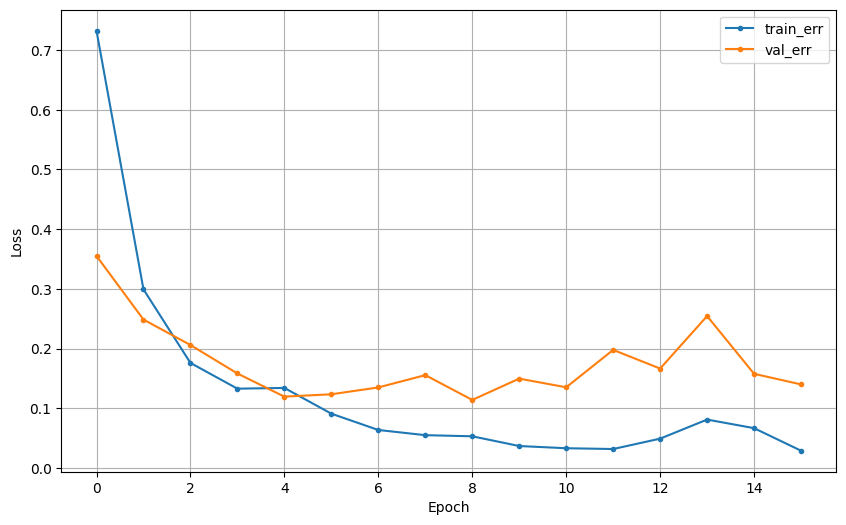

None
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
accuracy : 0.9489953632148377
[[219   2   0]
 [  2 188  15]
 [  1  13 207]]
              precision    recall  f1-score   support

      LAYING     0.9865    0.9910    0.9887       221
     SITTING     0.9261    0.9171    0.9216       205
    STANDING     0.9324    0.9367    0.9345       221

    accuracy                         0.9490       647
   macro avg     0.9483    0.9482    0.9483       647
weighted avg     0.9489    0.9490    0.9489       647



In [175]:
# 모델링
nfeatures = x_train.shape[1]
#clear_session()

model_0 = Sequential([Input(shape = (nfeatures, )),
                     Dense(128, activation = 'relu'),
                     Dropout(0.2),
                     Dense(64, activation = 'relu'),
                     Dropout(0.2),
                     Dense(32, activation = 'relu'),
                     Dropout(0.2),
                     Dense(3, activation = 'softmax')])
model_0.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy')

min_de = 0.001
pat = 7

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

hist3 = model_0.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0, callbacks = [es]).history
print(dl_history_plot(hist3))

# 성능
pred = model_0.predict(x_val)
pred = np.argmax(pred, axis = 1)

print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred, digits = 4, target_names = encoder_0.classes_))

#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [172]:
# 동적 데이터 분리 i = 1 -> data_1
i = 1
data = data01_train
globals()[f'data_{i}'] = data[data['is_dynamic'] == i]

target = 'Activity'
x = globals()[f'data_{i}'].drop(['is_dynamic', target], axis = 1)
y = globals()[f'data_{i}'].loc[:, target]

# 전처리
scaler = StandardScaler()
x = scaler.fit_transform(x)

encoder_1 = LabelEncoder()
y = encoder_1.fit_transform(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

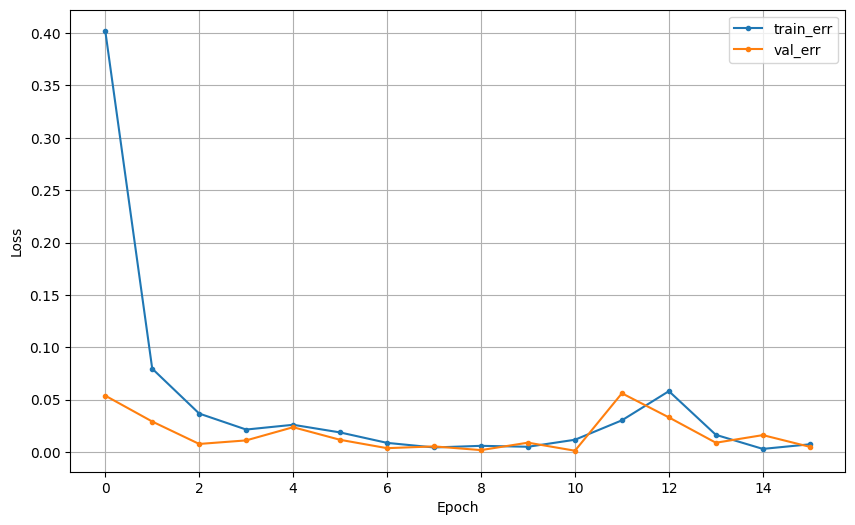

None
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
accuracy : 0.9943396226415094
[[194   1   1]
 [  0 163   0]
 [  0   1 170]]
                    precision    recall  f1-score   support

           WALKING     1.0000    0.9898    0.9949       196
WALKING_DOWNSTAIRS     0.9879    1.0000    0.9939       163
  WALKING_UPSTAIRS     0.9942    0.9942    0.9942       171

          accuracy                         0.9943       530
         macro avg     0.9940    0.9946    0.9943       530
      weighted avg     0.9944    0.9943    0.9943       530



In [173]:
# 모델링
nfeatures = x_train.shape[1]
#clear_session()

model_1 = Sequential([Input(shape = (nfeatures, )),
                     Dense(128, activation = 'relu'),
                     Dropout(0.2),
                     Dense(64, activation = 'relu'),
                     Dropout(0.2),
                     Dense(32, activation = 'relu'),
                     Dropout(0.2),
                     Dense(3, activation = 'softmax')])
model_1.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy')

min_de = 0.001
pat = 7

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

hist3 = model_1.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0, callbacks = [es]).history
print(dl_history_plot(hist3))

# 성능
pred = model_1.predict(x_val)
pred = np.argmax(pred, axis = 1)

print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred, digits = 4, target_names = encoder_1.classes_))

In [ ]:
path = '/content/drive/MyDrive/project3/'
model_0.save(path +'best_model_0.keras')
model_1.save(path +'best_model_1.keras')

### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [195]:
import tensorflow as tf
model_0 = tf.keras.models.load_model(path +'best_model_0.keras')
model_1 = tf.keras.models.load_model(path +'best_model_1.keras')

In [196]:
# 데이터 불러오기
data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')

In [197]:
def pipeline(data01_train, data01_test):

  # 컬럼 제거
  data01_train.drop('subject', axis = 1, inplace = True)
  data01_test.drop('subject', axis = 1, inplace = True)

  # 정적, 동적 레이블
  data01_train['is_dynamic'] = data01_train['Activity'].apply(lambda x : 0 if x in ['STANDING', 'SITTING', 'LAYING'] else 1)
  data01_test['is_dynamic'] = data01_test['Activity'].apply(lambda x : 0 if x in ['STANDING', 'SITTING', 'LAYING'] else 1)

  # x, y 분리
  target = 'is_dynamic'
  x_train = data01_train.drop(['Activity',target], axis = 1)
  y_train = data01_train.loc[:, target]

  x_test = data01_test.drop(['Activity',target], axis = 1)
  y_test = data01_test.loc[:, target]

  x_col_name = x_test.columns
  test_activity = data01_test['Activity']

  # 스케일링
  scaler = StandardScaler()
  x_train = scaler.fit_transform(x_train)

  scaler = StandardScaler()
  x_test = scaler.fit_transform(x_test)

  #------------1단계 모델링------------#
  nfeatures = x_train.shape[1]

  model = Sequential([Input(shape=(nfeatures,)),
                      Dense(1, activation='sigmoid')])
  model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
  model.fit(x_train, y_train, epochs = 50, validation_split = 0.2, verbose = 0)

  pred = model.predict(x_test)
  pred = np.where(pred > 0.5, 1, 0)

  #------------test data 데이터프레임 재생성------------#
  x_test = pd.DataFrame(x_test, columns = x_col_name)
  activity = pd.DataFrame(test_activity, columns = ['Activity'])
  pred = pd.DataFrame(pred, columns = ['is_dynamic'])
  data = pd.concat([x_test, activity], axis = 1)
  data = pd.concat([data, pred], axis = 1)

  #------------2단계 모델링------------#
  # 정적(0), 동적(1) 데이터 분리
  data_0 = data[data['is_dynamic'] == 0]
  idx_0 = data[data['is_dynamic'] == 0].index
  x_0 = data_0.drop(['is_dynamic','Activity'], axis = 1)
  y_0 = data_0.loc[:, 'Activity']
  y_0 = encoder_0.transform(y_0)

  data_1 = data[data['is_dynamic'] == 1]
  idx_1 = data[data['is_dynamic'] == 1].index
  x_1 = data_1.drop(['is_dynamic','Activity'], axis = 1)
  y_1 = data_1.loc[:, 'Activity']
  y_1 = encoder_1.transform(y_1)

  # 정적(0) 성능
  pred_0 = model_0.predict(x_0)
  pred_0 = np.argmax(pred_0, axis = 1)

  result = []
  result.append(accuracy_score(y_0, pred_0))
  result.append(confusion_matrix(y_0, pred_0))
  result.append(classification_report(y_0, pred_0, digits = 4, target_names = encoder_0.classes_))

  # 동적(1) 성능
  pred_1 = model_1.predict(x_1)
  pred_1 = np.argmax(pred_1, axis = 1)

  result.append(accuracy_score(y_1, pred_1))
  result.append(confusion_matrix(y_1, pred_1))
  result.append(classification_report(y_1, pred_1, digits = 4, target_names = encoder_1.classes_))

  return result

#### 2) test 셋으로 예측하고 평가하기

In [198]:
result = pipeline(data01_train, data01_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [200]:
# 정적(0) 결과
print(result[0])
print(result[1])
print(result[2])
print('-'*60)
# 동적(1) 결과
print(result[3])
print(result[4])
print(result[5])

0.8139255702280912
[[290   2   0]
 [  1 252   1]
 [  0 151 136]]
              precision    recall  f1-score   support

      LAYING     0.9966    0.9932    0.9949       292
     SITTING     0.6222    0.9921    0.7648       254
    STANDING     0.9927    0.4739    0.6415       287

    accuracy                         0.8139       833
   macro avg     0.8705    0.8197    0.8004       833
weighted avg     0.8811    0.8139    0.8030       833

------------------------------------------------------------
0.9153605015673981
[[181  22  25]
 [  0 195   0]
 [  0   7 208]]
                    precision    recall  f1-score   support

           WALKING     1.0000    0.7939    0.8851       228
WALKING_DOWNSTAIRS     0.8705    1.0000    0.9308       195
  WALKING_UPSTAIRS     0.8927    0.9674    0.9286       215

          accuracy                         0.9154       638
         macro avg     0.9211    0.9204    0.9148       638
      weighted avg     0.9243    0.9154    0.9137       638

